In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from pympc.geometry.polytope import Polytope
from pympc.geometry.convex_hull import orthogonal_projection_CHM
from pympc.geometry.nullspace_basis import nullspace_basis
import matplotlib.pyplot as plt
from itertools import combinations
from copy import copy

In [3]:
n_var = 3
n_cons = 10

x = [0,1]
u = [i for i in range(n_var) if i not in x]

A = np.random.randn(n_cons, n_var)
b = np.random.rand(n_cons, 1)
P = Polytope(A, b).assemble()

A_x = A[:, x]
A_u = A[:, u]

A_proj, b_proj, _ = orthogonal_projection_CHM(A, b, x)
P_proj = Polytope(A_proj, b_proj).assemble()


*** Convex Hull Method for Orthogonal Projections START ***
Inner 2D simplex found.
Expansion of the inner polytope started.
Facets found so far 9, vertices found so far 9, length of the last inflation 3.335316e-02.
Projection derived 0.051577091217 seconds: number of facets is 9, number of vertices is 9.
*** Convex Hull Method for Orthogonal Projections STOP ***



## outer approximation

In [4]:
from pympc.optimization.gurobi import linear_program

In [5]:
f_x = np.random.rand(len(x),1)
f = np.zeros((n_var, 1))
f[x,:] = f_x
sol = linear_program(-f, A, b)

In [6]:
A_outer = A_x[sol.active_set, :]
b_outer = b[sol.active_set,:]

In [7]:
T = nullspace_basis(A_u[sol.active_set, :].T).T

In [8]:
P_outer = Polytope(T.dot(A_outer), T.dot(b_outer))
P_outer.add_bounds(-.1*np.ones((2,1)), .1*np.ones((2,1)))
P_outer.assemble()

<pympc.geometry.polytope.Polytope instance at 0x106efee60>

In [9]:
def normalize(X):
    X = copy(X)
    for i in range(X.shape[1]):
        X.T[i] = X.T[i]/np.linalg.norm(X.T[i])
    return X
    
def select_conic_basis(x, X):
    x = normalize(x)
    X = normalize(X)
    n = X.shape[1]
    A = - np.eye(n)
    b = np.zeros((n,1))
    f = np.ones((n,1))
    sol = linear_program(f, A, b, X, x)
    basis_indices = [i for i in range(n) if i not in sol.active_set]
    conic_basis = X[:,basis_indices]
    return basis_indices

In [10]:
comb = [i for i in combinations(range(len(sol.active_set)),n_var-len(x)+1)]
A_outer = np.zeros((0, len(x)))
b_outer = np.zeros((0, 1))
for ind in comb:
    active_subset = [sol.active_set[i] for i in ind]
    T = nullspace_basis(A_u[active_subset, :].T).T
    A_outer = np.vstack((A_outer, T.dot(A_x[active_subset, :])))
    b_outer = np.vstack((b_outer, T.dot(b[active_subset, :])))
indices = select_conic_basis(f_x, A_outer.T)
A_outer = A_outer[indices,:]
b_outer = b_outer[indices,:]
P_outer = Polytope(A_outer, b_outer)
P_outer.add_bounds(-3*np.ones((2,1)), 3*np.ones((2,1)))
P_outer.assemble()

<pympc.geometry.polytope.Polytope instance at 0x106efe5f0>

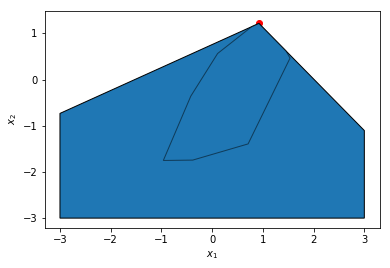

In [11]:
P_outer.plot()  
P_proj.plot(alpha=.5)
plt.scatter(sol.argmin[x[0],:], sol.argmin[x[1],:], color='r')
plt.show()